# Appendix E: Culminating reactor design example: multiple reversible reactions in packed bed reactor with heat exchange

This code contains four cells:
1. Description (this cell): Explains structure of code
2. Package import: Makes key programs available
3. Reactor simulation: Specify initial conditions, differential equations, final conditions, etc.
4. Plot generation: Plots outputs of reactor simulation
    
Three reactions are simulated here:
1. $ Formic$ $acid$ $(FA) \leftrightharpoons CO + H_2O $
2. $ Formic$ $acid$ $(FA) \leftrightharpoons CO_2 + H_2O $
3. $ CO + H_2O \leftrightharpoons CO_2 + H_2 $

Rate expressions simulated (not necessarily correct):
1. $r_1 = \frac{k_{1f} \cdot P_{FA}}{1+K_{FA}\cdot P_{FA} + K_{CO} \cdot P_{CO}}$
2. $r_2 = \frac{k_{2f} \cdot P_{FA}}{1+K_{FA}\cdot P_{FA} + K_{CO} \cdot P_{CO}}$
3. $r_3 = \frac{k_{3f} \cdot P_{CO} \cdot P_{H_2O} \cdot \biggl(1-\frac{Q_{P,3}}{K_{P,3}}\biggr)}{(1+K_{FA}\cdot P_{FA} + K_{CO} \cdot P_{CO})^2}$

**Instructions**:
1. Run cell 2 to start. This is required only once when notebook is first opened. Shortcut to run: "shift+enter"
2. Edit cell 3 to represent desired scenario. 
3. Run cell 4 to generate plots of reactor simulation.

*Note 1: this code is written to be understandable moreso than computationally efficient; it runs fast enough nonetheless.*

*Note 2: a "true divide" error may be thrown if attempting to divide by zero when generating selectivity/yield/reaction quotients. Do not worry about these; the code will run fine*

In [1]:
########## Cell 2: Import key packages ##########
import numpy as np                     # convenient data structures and math functions
import matplotlib.pyplot as plt        # plotting
from scipy.integrate import solve_ivp  # ODE solver

In [2]:
########## Cell 3: Reactor simulation ##########

### Gas constant
Rlatm   = 0.082057      # L atm / mol K
R       = 8.314         # J / mol K

### Inlet conditions
F0_FA   = 100           # molar formic acid flow rate in  // mol / s
y0_FA   = 1             # inlet mole fraction of formic acid
y0_CO2  = 0             
y0_H2   = 0             
y0_CO   = 0
y0_H2O  = 0
P0      = 2             # inlet pressure; atm
T0      = 400           # inlet temperature; K
gamma0  = 1             # initial pressure drop; P0/P0 = 1
alpha   = 0.001          # pressure drop parameter

F0      = F0_FA / y0_FA         # total inlet molar flow rate
v0      = F0 * Rlatm * T0 / P0  # total inlet volumetric flow rate
F0_CO2  = y0_CO2 * F0           # inlet CO2 molar flow rate
F0_H2   = y0_H2 * F0            # inlet H2 molar flow rate
F0_CO   = y0_CO * F0            # inlet CO molar flow rate
F0_H2O  = y0_H2O * F0           # inlet H2O molar flow rate

### Heat capacities ; approximate as temperature-independent
CP_FA  = 45.9          # J / mol K
CP_CO2 = 38.4          # J / mol K
CP_H2  = 28.8          # J / mol K
CP_CO  = 29.1          # J / mol K
CP_H2O = 33.6          # J / mol K

dCP_1 = -CP_FA + CP_CO2 + CP_H2          # Change in mixture heat capacity due to reaction 1
dCP_2 = -CP_FA + CP_CO + CP_H2O          # Change in mixture heat capacity due to reaction 2
dCP_3 = -CP_H2O -CP_CO + CP_H2 + CP_CO2  # Change in mixture heat capacity due to reaction 3

CPsum = y0_FA * CP_FA + y0_CO2 * CP_CO2 + y0_H2 * CP_H2 + y0_CO * CP_CO + y0_H2O * CP_H2O # Initial weighted sum of heat capacities

### Reaction details
dHrxn_1_298K = -14.9*1000    # enthalpy of reaction 1 at 298K; J / mol
dSrxn_1_298K = 95.5          # entropy of reaction 1 at 298K; J / mol K
k0_1f = 3.8*10**7             # rate constant pre-exponential factor for reaction 1; mol / kgcat s
Ea_1 = 50000                 # activation energy for reaction 1; J / mol

dHrxn_2_298K = 26.3*1000     # J / mol
dSrxn_2_298K = 137.5         # J / mol K
k0_2f = 80*10**7            # mol / kgcat s
Ea_2 = 68000                 # J / mol

dHrxn_3_298K = dHrxn_1_298K - dHrxn_2_298K
dSrxn_3_298K = dSrxn_1_298K - dSrxn_2_298K
k0_3f = 2*10**18             # mol / kgcat atm s
Ea_3 = 100000                # J / mol

### Coolant/heat transfer fluid details
Ta = 300 # reactor inlet coolant temperature; K
Uap = 15 # heat transfer coefficient; J / kgcat s

### Define initial conditions array
U0 = [F0_FA,F0_CO2,F0_H2,F0_CO,F0_H2O,T0,gamma0]

def pbr_heatx(t,U): # Define function which calculates differential changes in dependent parameters
    
    ### Assign dependent parameter variables to inputs ; order must match initial conditions array
    F_FA  = U[0]
    F_CO2 = U[1]
    F_H2  = U[2]
    F_CO  = U[3]
    F_H2O = U[4]
    T     = U[5]
    gamma = U[6]

    ### Calculate volumetric flow rate change
    F = F_FA + F_CO2 + F_H2 + F_CO + F_H2O
    P = P0 * gamma
    v = v0 * (F/F0) * (T/T0) * (P0/P)
    
    ### Calculate mole fractions of components
    y_FA  = F_FA / F
    y_CO2 = F_CO2 / F
    y_H2  = F_H2 / F
    y_CO  = F_CO / F
    y_H2O = F_H2O / F
    
    ### Calculate partial pressures of components
    P_FA  = P * y_FA
    P_CO2 = P * y_CO2
    P_H2  = P * y_H2
    P_CO  = P * y_CO
    P_H2O = P * y_H2O
    
    ### Reaction quotient for reversible third reaction; use if-else to avoid dividing by zero initially
    if P_CO == 0 or P_H2O == 0:
        Q3 = 0
    else:      
        Q3 = P_H2 * P_CO2 / (P_H2O * P_CO)
    
    ### Calculate temperature-dependent parameters
    dHrxn_1 = dHrxn_1_298K + dCP_1 * (T-298)
    k1f = k0_1f * np.exp(-Ea_1/R/T)
    
    dHrxn_2 = dHrxn_2_298K + dCP_2 * (T-298)
    k2f = k0_2f * np.exp(-Ea_2/R/T)
    
    dHrxn_3 = dHrxn_3_298K + dCP_3 * (T-298)
    dSrxn_3 = dSrxn_3_298K + dCP_3 * np.log(T/298)
    dGrxn_3 = dHrxn_3 - T * dSrxn_3
    K3 = np.exp(-dGrxn_3/R/T)
    k3f = k0_3f*np.exp(-Ea_3/R/T)
    
    ### Site blocking parameters for reaction rate expressions
    K_FA = 2E-8 * np.exp(20000/R/T)
    K_CO = 3E-8 * np.exp(90000/R/T)
    
    ### Reaction rate calculations
    r1 = (k1f*P_FA)/(1+K_FA*P_FA+K_CO*P_CO)
    r2 = (k2f*P_FA)/(1+K_FA*P_FA+K_CO*P_CO)
    r3 = (k3f*P_CO*P_H2O*(1-Q3/K3))/(1+K_FA*P_FA+K_CO*P_CO)**2
    
    ### Component reaction rates
    r_FA  = -r1 - r2
    r_CO2 =  r1 + r3
    r_H2  =  r1 + r3
    r_CO  =  r2 - r3
    r_H2O =  r2 - r3
    
    ### Material balances
    dF_FA  = r_FA
    dF_CO2 = r_CO2
    dF_H2  = r_H2
    dF_CO  = r_CO
    dF_H2O = r_H2O
    
    ### Heat terms
    Qg = -(r1*dHrxn_1+r2*dHrxn_2+r3*dHrxn_3)
    Qr = Uap * (T-Ta)
    
    ### CPjFj sum
    CPjFj_sum = CP_FA*F_FA + CP_CO2*F_CO2 + CP_H2*F_H2 + CP_H2O*F_H2O + CP_CO*F_CO
    
    ### Temperature differential equations from energy balances
    dT = (Qg-Qr)/CPjFj_sum
    
    ### Pressure drop 
    dgamma = -alpha / (2*gamma) * (T/T0) * (F/F0)
        
    ### Fit equations into array
    dU=np.zeros(len(U))
    dU[0] = dF_FA
    dU[1] = dF_CO2
    dU[2] = dF_H2
    dU[3] = dF_CO
    dU[4] = dF_H2O
    dU[5] = dT
    dU[6] = dgamma 
    
    ### Reorganize list to fit required dimensions 
    dU = np.array(dU).tolist()
    
    return dU

### Specify integration limits
Wlim = (0,200)
Wlist = np.linspace(Wlim[0],Wlim[1],num=1001) # Not essential; report 1001 evenly-spaced evaluations

### Integrate
soln = solve_ivp(pbr_heatx,Wlim,U0,t_eval=Wlist,method='Radau')

### Interpret outputs
W = soln.t
U = soln.y.T

F_FA  = U[:,0]
F_CO2 = U[:,1]
F_H2  = U[:,2]
F_CO  = U[:,3]
F_H2O = U[:,4]
T     = U[:,5]
gamma = U[:,6]

### Perform additional calculations
X_FA = (F0_FA-F_FA)/F0_FA
S_H2_H2O= F_H2 / F_H2O
Y_H2 = F_H2 / (F0_FA)
Y_H2O = F_H2O / (F0_FA)
S_H2 = Y_H2 / (Y_H2+Y_H2O)
S_H2O = Y_H2O / (Y_H2+Y_H2O)

### Copy and paste lines from the differential equations section that convert from flow rates to reaction rates.
### Note that you will run into a roblem with Q3 because the if,else statement won't work for the Q3 vector unless
### you iterate over it. Instead calculate the Q3 vector, then just replace the first element (which should be 'nan')
#with 0 (i.e., Q3[0]=0)

 ### Calculate volumetric flow rate change
F = F_FA + F_CO2 + F_H2 + F_CO + F_H2O
P = P0 * gamma
v = v0 * (F/F0) * (T/T0) * (P0/P)

### Calculate mole fractions of components
y_FA  = F_FA / F
y_CO2 = F_CO2 / F
y_H2  = F_H2 / F
y_CO  = F_CO / F
y_H2O = F_H2O / F

### Calculate partial pressures of components
P_FA  = P * y_FA
P_CO2 = P * y_CO2
P_H2  = P * y_H2
P_CO  = P * y_CO
P_H2O = P * y_H2O

### Reaction quotient for third reaction; use if-else to avoid dividing by zero initially
Q3 = (P_H2 * P_CO2) / (P_H2O * P_CO)
Q3[0]=0

### Calculate temperature-dependent parameters
dHrxn_1 = dHrxn_1_298K + dCP_1*(T-298)
k1f = k0_1f * np.exp(-Ea_1/R/T)

dHrxn_2 = dHrxn_2_298K + dCP_2*(T-298)
k2f = k0_2f * np.exp(-Ea_2/R/T)

dHrxn_3 = dHrxn_3_298K + dCP_3*(T-298)
dSrxn_3 = dSrxn_3_298K + dCP_3 * np.log(T/298)
dGrxn_3 = dHrxn_3 - T * dSrxn_3
K3 = np.exp(-dGrxn_3/R/T)
k3f = k0_3f * np.exp(-Ea_3/R/T)

### Site blocking parameters
K_FA = 2E-8*np.exp(20000/R/T)
K_CO = 3E-8*np.exp(90000/R/T)

### Rate calculation
r1 = (k1f*P_FA)/(1+K_FA*P_FA+K_CO*P_CO)
r2 = (k2f*P_FA)/(1+K_FA*P_FA+K_CO*P_CO)
r3 = (k3f*P_CO*P_H2O*(1-Q3/K3))/(1+K_FA*P_FA+K_CO*P_CO)**2

### Report key values
print('Final conversion:','{0:,.2f}'.format(X_FA[-1]))
print('Final H2/H2O selectivity:','{0:,.1f}'.format(S_H2_H2O[-1]))

Final conversion: 0.20
Final H2/H2O selectivity: 11.8


C:\Users\neaga\AppData\Local\Temp\ipykernel_18196\2761356569.py:183: RuntimeWarning: invalid value encountered in true_divide
  S_H2_H2O= F_H2 / F_H2O
C:\Users\neaga\AppData\Local\Temp\ipykernel_18196\2761356569.py:186: RuntimeWarning: invalid value encountered in true_divide
  S_H2 = Y_H2 / (Y_H2+Y_H2O)
C:\Users\neaga\AppData\Local\Temp\ipykernel_18196\2761356569.py:187: RuntimeWarning: invalid value encountered in true_divide
  S_H2O = Y_H2O / (Y_H2+Y_H2O)
C:\Users\neaga\AppData\Local\Temp\ipykernel_18196\2761356569.py:214: RuntimeWarning: invalid value encountered in true_divide
  Q3 = (P_H2 * P_CO2) / (P_H2O * P_CO)


C:\Users\neaga\AppData\Local\Temp\ipykernel_18196\1749664682.py:45: RuntimeWarning: divide by zero encountered in log
  ax5.plot(W,np.log(r3),'-.y')


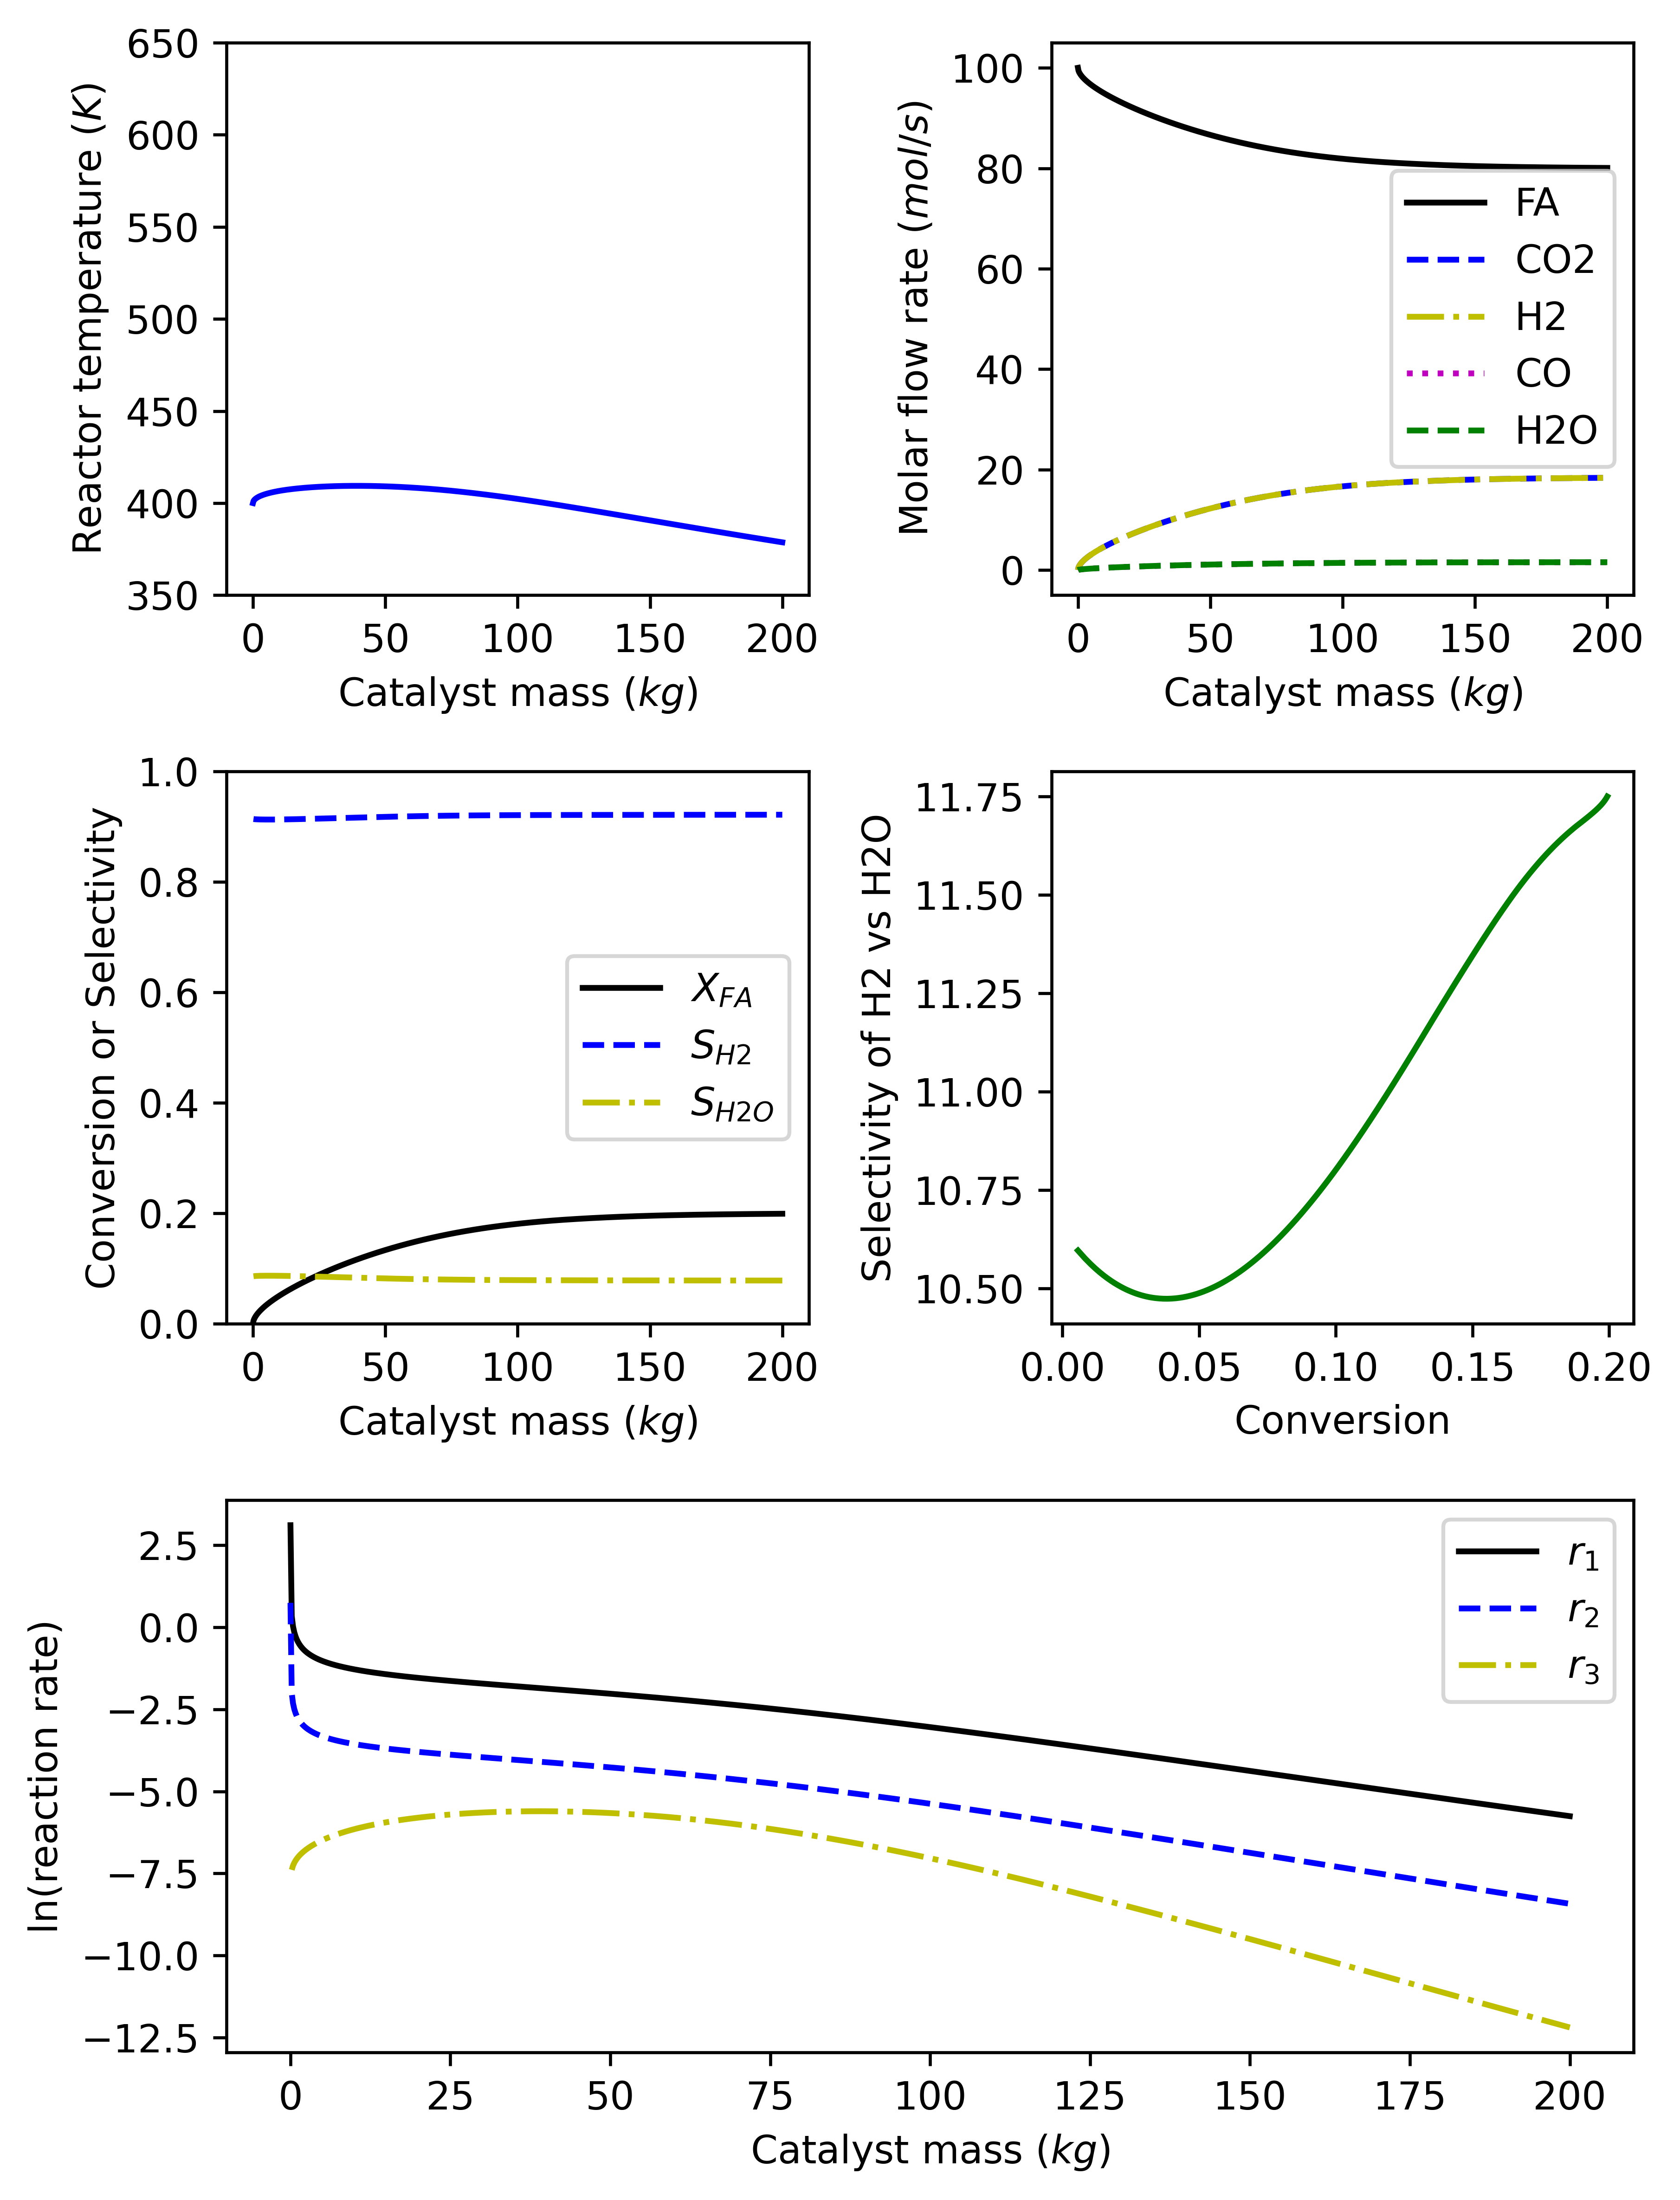

In [3]:
########## Cell 4: Generate plots ##########

fig = plt.figure(figsize=(6,8),dpi=600) # 6 in wide, 8 in tall, 600 dots per inch
ax1 = plt.subplot(321) # subplot 1 would be first plot of 6 with 3 rows and two columns
ax2 = plt.subplot(322) # subplot 2 would be second plot of 6 ''
ax3 = plt.subplot(323) # subplot 3 would be third plot of 6 ''
ax4 = plt.subplot(324) # subplot 4 would be fourth plot of 6 ''
ax5 = plt.subplot(313) # subplot 5 would be third plot of 3 with 3 rows and 1 column

### Temperature T vs catalyst weight W
ax1.plot(W,T,'-b')
ax1.set_xlabel('Catalyst mass ($kg$)')
ax1.set_ylabel('Reactor temperature ($K$)')
ax1.set_ylim([350,650])

### Flow rates F_j vs W
ax2.plot(W,F_FA,'-k')    # solid black line
ax2.plot(W,F_CO2,'--b')  # dashed blue line
ax2.plot(W,F_H2,'-.y')   # dash-dot yellow line
ax2.plot(W,F_CO,':m')    # dotted maroon line
ax2.plot(W,F_H2O,'--g')  # dashed green line
ax2.legend(['FA','CO2','H2','CO','H2O'])
ax2.set_xlabel('Catalyst mass ($kg$)')
ax2.set_ylabel('Molar flow rate ($mol/s$)')

### Conversion X_FA and yields Y_j vs W
ax3.plot(W,X_FA,'-k')
#ax3.plot(W,Y_H2,'--b')
#ax3.plot(W,Y_H2O,'-.y')
ax3.plot(W,S_H2,'--b')
ax3.plot(W,S_H2O,'-.y')
ax3.legend(['$X_{FA}$','$S_{H2}$','$S_{H2O}$'])
ax3.set_xlabel('Catalyst mass ($kg$)')
ax3.set_ylabel('Conversion or Selectivity')
ax3.set_ylim([0,1])

### Selectivity of H2/H2O vs conversion
ax4.plot(X_FA,S_H2_H2O,'-g')
ax4.set_xlabel('Conversion')
ax4.set_ylabel('Selectivity of H2 vs H2O')

### Reaction rates (logs) vs W
ax5.plot(W,np.log(r1),'-k')
ax5.plot(W,np.log(r2),'--b')
ax5.plot(W,np.log(r3),'-.y')
ax5.legend(['$r_1$','$r_2$','$r_3$'])
ax5.set_xlabel('Catalyst mass ($kg$)')
ax5.set_ylabel('ln(reaction rate)')

fig.tight_layout()
plt.show()